In [94]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

# Getting to know the data

In [2]:
df = pd.read_csv('precos_imoveis.csv')

In [3]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [30]:
profile = ProfileReport(df)

In [34]:
profile

In [4]:
#For sure 'Id' shouldn't be a feature and 'SalePrice' is what we want to predict
y = df.SalePrice
del df['Id'],df['SalePrice']

# I have to process the features

In [5]:
#piece of code that tries to get the discrete features
def get_discrete_features(df):
    
    discrete_features = []
    is_discrete = []
    d = df.dtypes.to_dict()
    for column in df.columns:
        #if the type of the column is a string
        if d[column] == 'O':
            discrete_features.append(column)
            is_discrete.append(True)
        #if all unique values are the only possible values
        elif (len(df[column].unique()) == df[column].max()) or (len(df[column].unique()) == df[column].max()-1):
            discrete_features.append(column)
            is_discrete.append(True)
        else:
            is_discrete.append(False)
            
    is_discrete = np.array(is_discrete)
    return discrete_features,is_discrete

In [6]:
discrete_features,is_discrete = get_discrete_features(df)
#I know MSSubClass is discrete and it fails my test
discrete_features.append('MSSubClass')
is_discrete[0] = True

In [7]:
df[discrete_features].head()

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1       RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   
2       RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
3       RL   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl   
4       RL   Pave   NaN      IR1         Lvl    AllPub       FR2       Gtl   

  Neighborhood Condition1  ... GarageQual GarageCond PavedDrive  PoolQC  \
0      CollgCr       Norm  ...         TA         TA          Y     NaN   
1      Veenker      Feedr  ...         TA         TA          Y     NaN   
2      CollgCr       Norm  ...         TA         TA          Y     NaN   
3      Crawfor       Norm  ...         TA         TA          Y     NaN   
4      NoRidge       Norm  ...         TA         TA          Y     NaN   

   Fence MiscFeature MoSold SaleType SaleCondition MSSubClass  
0    NaN         NaN      2       WD        Normal         60  
1    NaN         NaN      5       WD        Normal         20  
2    NaN         NaN      9       WD        Normal         60  
3    NaN         NaN      2       WD       Abnorml         70  
4    NaN         NaN     12       WD        Normal         60  

[5 rows x 48 columns]

## First, dealing with the continuous variables

In [8]:
#I want to add a new column that says a given feature was NaN and substitute the NaN for the mean
for column in df.columns[~is_discrete]:
    has_na = df[column].isna().sum() > 0
    if has_na:
        x = df[column].values[~df[column].isna()]
        #replaces NaNs with the mean
        df[column] = df[column].fillna(np.mean(x))
        #adds a new column saying the value was missing
        df[column + '_missing'] = df[column].isna()

In [9]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## Now dealing with the discrete variables. First try to encode with dummy encoding

In [10]:
df[discrete_features] = df[discrete_features].fillna('Not Info')

In [11]:
df[discrete_features].head()

MSZoning Street     Alley LotShape LandContour Utilities LotConfig  \
0       RL   Pave  Not Info      Reg         Lvl    AllPub    Inside   
1       RL   Pave  Not Info      Reg         Lvl    AllPub       FR2   
2       RL   Pave  Not Info      IR1         Lvl    AllPub    Inside   
3       RL   Pave  Not Info      IR1         Lvl    AllPub    Corner   
4       RL   Pave  Not Info      IR1         Lvl    AllPub       FR2   

  LandSlope Neighborhood Condition1  ... GarageQual GarageCond PavedDrive  \
0       Gtl      CollgCr       Norm  ...         TA         TA          Y   
1       Gtl      Veenker      Feedr  ...         TA         TA          Y   
2       Gtl      CollgCr       Norm  ...         TA         TA          Y   
3       Gtl      Crawfor       Norm  ...         TA         TA          Y   
4       Gtl      NoRidge       Norm  ...         TA         TA          Y   

     PoolQC     Fence MiscFeature MoSold SaleType SaleCondition MSSubClass  
0  Not Info  Not Info    Not Info      2       WD        Normal         60  
1  Not Info  Not Info    Not Info      5       WD        Normal         20  
2  Not Info  Not Info    Not Info      9       WD        Normal         60  
3  Not Info  Not Info    Not Info      2       WD       Abnorml         70  
4  Not Info  Not Info    Not Info     12       WD        Normal         60  

[5 rows x 48 columns]

In [74]:
X = pd.get_dummies(df,drop_first=True)

In [13]:
X.columns.values

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'LotFrontage_missing', 'MasVnrArea_missing',
       'GarageYrBlt_missing', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Pave', 'Alley_Not Info', 'Alley_Pave',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'Utilities_NoSeWa',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
       'LotConfig_Inside', 'LandSlope_Mod', 'La

In [75]:
#checking if there are any NaNs remaining (it shouldn't)
X.isna().sum()

MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 264, dtype: int64

In [15]:
#apply SelectKBest regression to extract top 3 best features
bestfeatures = SelectKBest(score_func=mutual_info_regression, k=3)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
featScores = pd.Series(list(featureScores.Score), index=X.columns)

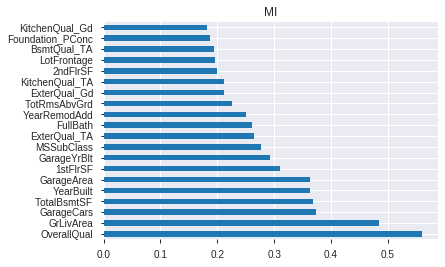

In [20]:
featScores.nlargest(20).plot(kind='barh',title='MI')

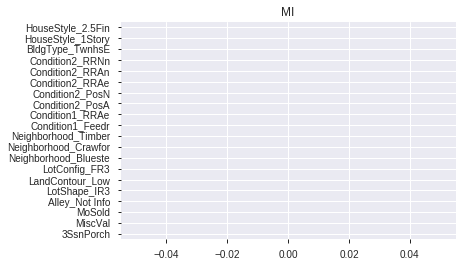

In [25]:
featScores.nsmallest(20).plot(kind='barh',title='MI')

# Now lets try to fit a regressor

In [86]:
#There are no reasons why I should keep features with zero MI
X_all = X[featScores[featScores>0].index]

In [87]:
clf = RandomForestRegressor(n_estimators=10)
scores = cross_val_score(clf, X_all, y, cv=10,scoring = 'explained_variance')
scores,np.mean(scores),np.std(scores)

(array([0.84402027, 0.88854963, 0.90033656, 0.77414514, 0.89738107,
        0.8524751 , 0.88593261, 0.8567062 , 0.77926432, 0.86054683]),
 0.8539357725573729,
 0.04284465624578697)

## It looks promising. Let's do a GridSearch now to tune the parameters

In [65]:
pipe = Pipeline([('regressor' , RandomForestRegressor())])

param_grid = [
    {'regressor' : [RandomForestRegressor()],
    'regressor__n_estimators' : np.logspace(1, 2.69, 10).astype('int'), # values from 10 to ~500
    'regressor__max_depth' : np.logspace(0, 1.47, 10).astype('int') # values from 1 to ~30
    }]

# Create grid search object
gs = GridSearchCV(pipe, param_grid = param_grid, cv = 10, verbose=True, n_jobs=-1,scoring = 'explained_variance')
gs.fit(X_all,y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 13.2min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('regressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                              min_weight_fraction_leaf=0.0,
               

In [67]:
gs.best_params_

{'regressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=29,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=56,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False),
 'regressor__max_depth': 29,
 'regressor__n_estimators': 56}

In [102]:
best_clf = RandomForestRegressor(n_estimators=56,max_depth=29)
scores = cross_val_score(best_clf, X, y, cv=10,scoring = 'explained_variance')
scores,np.mean(scores),np.std(scores)

(array([0.85912437, 0.88755539, 0.92016326, 0.76540065, 0.88550338,
        0.88308429, 0.88841446, 0.88282181, 0.76279245, 0.84660955]),
 0.8581469600535909,
 0.050432646975538925)

## Trying the same with a linear regressor

In [112]:
lrg = LinearRegression()
scores = cross_val_score(lrg, X_all, y, cv=10,scoring = 'explained_variance')
scores,np.mean(scores),np.std(scores)

(array([ 0.88121597,  0.85908137,  0.89659299,  0.77287334,  0.89436807,
         0.80004561,  0.87227396,  0.88491583,  0.62951823, -1.44838441]),
 0.6042500955078383,
 0.6886659937373105)